In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from collections import deque



import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [2]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [3]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())

/workspace/slp_jaspar/autoencoder/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
MARIO               1713
YOUNG_LINK          1447
ROY                 1272
BOWSER               940
KIRBY                556
PICHU                230
Name: labels, dtype: int64


In [4]:
dataset.dataset.head()

,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\727e819f-8cb3-4c3f-bf0a-ceefa9e41c...,5606,FALCO
1,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\76fe3db5-60de-46bb-8f0d-80d48822a8...,5754,FALCO
2,POKEMON_STADIUM,2,True,MARTH,HUMAN,HUMAN,mango\MARTH\7e6b417f-249d-4629-b6dc-2fe1d95d8f...,6213,MARTH
3,FOUNTAIN_OF_DREAMS,2,True,FOX,HUMAN,HUMAN,mango\FOX\32305eaf-71d8-46e5-a8a1-2c7c890a9baf...,7621,FOX
4,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\a5396c32-6f2c-4b88-8582-f8b875bb55...,7840,FALCO


In [5]:
labels_order =  dataset.number_of_segments_per_game(60,5000)
print(labels_order)
labels_order = labels_order['Label'].values


             Label   Count   Shift
0              FOX  103069  193497
1            FALCO   90717  168117
2            MARTH   53728  106569
3   CAPTAIN_FALCON   38006   70125
4            SHEIK   27623   59145
5            PEACH   17438   39398
6       JIGGLYPUFF   16374   35581
7            SAMUS    9524   23031
8     ICE_CLIMBERS    6849   15620
9        GANONDORF    6655   12805
10           YOSHI    5725   12226
11           LUIGI    5230   11464
12        DR_MARIO    4202    9062
13         PIKACHU    4096    8991
14            LINK    2502    5598
15            NESS    2306    5812
16     DONKEY_KONG    2026    4333
17  GAME_AND_WATCH    1967    3693
18          MEWTWO    1775    4511
19           MARIO    1713    3824
20      YOUNG_LINK    1447    3278
21             ROY    1272    2685
22          BOWSER     940    2196
23           KIRBY     556    1237
24           PICHU     230     491


In [6]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  public\FALCO\bee06d45-fca6-437f-969a-901efa166...   28801             1   
1  mango\FALCO\44e0962b-fdf7-4a16-acbe-61b5e5d609...   27200             1   
2  ranked\FALCO\2f51bb81-4304-4c6d-ac53-960aba87c...   26024             1   
3  ranked\FALCO\69cf9bb4-5f80-4e67-850d-ce0d7da1d...   25128             1   
4  ranked\FALCO\04257d15-f02f-4001-a191-37b97d2ed...   24323             1   

  labels  encoded_labels  
0  FALCO               4  
1  FALCO               4  
2  FALCO               4  
3  FALCO               4  
4  FALCO               4  


In [7]:
# train_df, test_df = dataset.all_segments_train_test_split_dataframes(60, proportion_of_segments=1, test_ratio = .2, val = False)
# porportion = .01
# train_df = train_df.sample(frac=porportion, random_state = 42)
# test_df = test_df.sample(frac=porportion, random_state = 42)


In [8]:
print(train_df.shape)
print(test_df.shape)
print(test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]))

(100000, 6)
(25000, 6)
0.2


In [9]:
train_df.head()

,player_inputs_np_sub_path,labels,encoded_labels,segment_start_index,segment_index,segment_length
0,mango\FALCO\b3c63d9d-efb7-4544-bdd6-9da7e221f1...,FALCO,4,0,0,60
1,mango\FALCO\a24ef3f0-ab56-47e6-af18-5905aa43af...,FALCO,4,0,0,60
2,mango\FALCO\24b523a3-18da-4ba2-a986-d0c99b6228...,FALCO,4,0,0,60
3,mango\FALCO\60e0d81b-e0bd-420c-8fce-fe2b11645c...,FALCO,4,0,0,60
4,public\FALCO\b0925bbb-c009-49db-80e6-6985d4756...,FALCO,4,0,0,60


In [10]:
class TrainingDataset(Dataset):
    """
    Custom dataset for loading game segments from compressed numpy files.
    """
    def __init__(self, df, transform=None):
        self.file_paths = df['player_inputs_np_sub_path'].to_numpy()
        self.encoded_labels = df['encoded_labels'].to_numpy()
        self.segment_start_index = df['segment_start_index'].to_numpy()
        # self.segment_index = df['segment_index'].to_numpy()
        self.segment_length = df['segment_length'].to_numpy()
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the specified index."""
        with gzip.open('/workspace/melee_project_data/input_np/' + self.file_paths[idx].replace('\\','/'), 'rb') as f:
            segment = np.load(f)
        
        # Start and end of the segment
        segment_start = self.segment_start_index[idx]
        segment_end = self.segment_start_index[idx] + self.segment_length[idx]
        
        segment = segment[:,int(segment_start):int(segment_end)]
        
        if self.transform:
            transformed = np.zeros((13,60))
            transformed[0,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] > 0)
            transformed[1,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] < 0)
            transformed[2,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] > 0)
            transformed[3,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] < 0)
            transformed[4,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] > 0)
            transformed[5,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] < 0)
            transformed[6,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] > 0)
            transformed[7,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] < 0)
            transformed[8:,:] = segment[4:]
            segment = transformed
            
        
        # Convert to PyTorch tensors
        segment_tensor = torch.from_numpy(segment).float()
        # label_tensor = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        return segment_tensor#, label_tensor
    
def prepare_data_loaders(train_df, test_df, batch_size, num_workers):
    # Initialize datasets
    train_dataset = TrainingDataset(train_df,True)
    # val_dataset = TrainingDataset(file_paths_val, labels_val)
    test_dataset = TrainingDataset(test_df,True)

    # Initialize data loaders
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True,persistent_workers=True),
        'test': DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True),
        # 'val': DataLoader(val_dataset, batch_size=2**9, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True)
    }
    return loaders



# ''' Get a batch of data to see the size if we want that information. ''' 
# data_loader_iterator = iter(loaders['train'])
# first_batch = next(data_loader_iterator)
# print(first_batch.shape)



In [11]:
def train_model(model, criterion, optimizer, loaders, device, num_epochs=1,rolling_loss_number = 100):
    scaler = GradScaler()  # Initialize the gradient scaler

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        total = 0
        rolling_loss = deque(maxlen=rolling_loss_number)
        rolling_total = deque(maxlen=rolling_loss_number)
        
        for batch_number, target_cpu in enumerate(train_loader_tqdm):
            target_gpu = target_cpu.to(device)
            
            # Resets the optimizer
            optimizer.zero_grad()
            
            # Runs the forward pass with autocasting.
            with autocast():
                output_gpu = model(target_gpu)
                loss = criterion(output_gpu , target_gpu) / (9 * 60 * target_cpu.size(0))
                # loss = criterion(output_gpu, target_gpu) 

                # print(loss)
            
            # Scales loss and calls backward() to create scaled gradients
            scaler.scale(loss).backward()
            
            # Clip gradients to avoid explosion
            scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # Before calling step(), check for inf or NaN values in the gradients
            if any(torch.isinf(p.grad).any() for p in model.parameters() if p.grad is not None):
                print("Warning: inf values in gradients!")
            elif any( torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
                print("Warning: NaN values in gradients!")
                
            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)
            
            # Updates the scale for next iteration.
            scaler.update()

            # Update progress
            # train_loss += loss.item()
            # total += target_gpu.size(0) / (9 * 60 * target_cpu.size[0])
            batch_total = target_gpu.size(0)
            rolling_total.append(batch_total)
            current_batch_loss = loss.item() 
            rolling_loss.append(current_batch_loss * target_cpu.size(0))
            
            train_loader_tqdm.set_postfix(loss=f'{sum(rolling_loss) / sum(rolling_total):.10f}')
            # train_loader_tqdm.set_postfix(loss=f'{sum(rolling_loss) / sum(rolling_total):.10f}')

            
            # i += 1
            # if i > 10:
            #     break


def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu) / ((32 * 16 * 4) * 13 * 60)
            
            
            total += target_gpu.shape[0] / (32 * 16 * 4)
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (total):.10f}') 
            
    print(f'Evaluated Loss: {eval_loss / total:.10f}')
    

In [12]:
from ResNet_Autoencoder_Model_Baseline_2 import ResNet_Autoencoder

channels = 13

# Build model
model = ResNet_Autoencoder(channels).to('cuda')

# With the size of an input we can get a model summary.
summary(model, input_size=(channels, 60))

# Check that the output shape and target shape match
# training_example = torch.rand(9, 2 ** 12).to('cuda')
# print('Target shape:', training_example.shape)
# model.eval()
# output = model(training_example)
# print('Output shape:', output.shape)

## Optionally compile the model
# import torch_tensorrt
# model = torch.compile(model, mode = 'default')
# model = torch.compile(model,mode = 'max-autotune')
# model = torch.compile(model, backend="torch_tensorrt")
# model = torch.compile(model, backend="torch_tensorrt",mode = 'max-autotune')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 60]             896
       BatchNorm1d-2               [-1, 64, 60]             128
              ReLU-3               [-1, 64, 60]               0
            Conv1d-4               [-1, 64, 60]          12,352
       BatchNorm1d-5               [-1, 64, 60]             128
              ReLU-6               [-1, 64, 60]               0
            Conv1d-7              [-1, 256, 60]          16,640
       BatchNorm1d-8              [-1, 256, 60]             512
            Conv1d-9              [-1, 256, 60]           3,584
      BatchNorm1d-10              [-1, 256, 60]             512
             ReLU-11              [-1, 256, 60]               0
Encoder_Bottleneck-12              [-1, 256, 60]               0
           Conv1d-13               [-1, 64, 60]          16,448
      BatchNorm1d-14               [-1

In [13]:
class CustomLoss(nn.Module,):
    def __init__(self, batch_size):
        super(CustomLoss, self).__init__()
        
        self.BCE = nn.BCEWithLogitsLoss(reduce='sum')
        self.MSE = nn.MSELoss(reduce='sum')
        self.batch_size = batch_size

    def forward(self, pred, target):
        mse_loss = self.MSE(pred[:4], target[:4]) 
        bce_loss = self.BCE(pred[4:], target[4:]) 
        return mse_loss + bce_loss
    

In [14]:
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

torch.autograd.set_detect_anomaly(False)
# Pepare data loaders
batch_size =  32 * 16 * 4
num_workers = 22
loaders = prepare_data_loaders(train_df, test_df, batch_size, num_workers)

# class LInfinityLoss(nn.Module):
#     def __init__(self):
#         super(LInfinityLoss, self).__init__()

#     def forward(self, predictions, targets):
#         # Compute the infinity norm of the difference
#         return torch.max(torch.abs(predictions - targets))

# class LPNormLoss(nn.Module):
#     def __init__(self, p=2):
#         super(LPNormLoss, self).__init__()
#         self.p = p

#     def forward(self, predictions, targets):
#         # Compute the lp norm of the difference
#         return torch.norm(predictions - targets, p=self.p) ** self.p


    
    
    
    
# Example usage:
# criterion = LPNormLoss(p=2) 
# criterion = LInfinityLoss()
criterion = nn.MSELoss(reduction = 'sum')

# criterion = CustomLoss(batch_size)

optimizer = Adam(model.parameters(), lr=0.0005)
num_epochs = 1

# This seems to sometimes help
# gc.collect()
# torch.cuda.empty_cache()
# Train the model
# start_time = time.time()
train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# print(f'Batch Size: {batch_size}, Training time: {time.time() - start_time:.2f}')

# Again, this sometimes seems to help
# gc.collect()
# torch.cuda.empty_cache()

# Evaluate the trained model
# evaluate_model(model, criterion, loaders, 'test', 'cuda')

Epoch 1/1:  45%|████▍     | 22/49 [00:06<00:03,  7.18batch/s, loss=0.2574307590]

In [ ]:
def predict(model, loaders, loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit='batch')
        
        for _, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            predictions.append(output_gpu.cpu().numpy())
            targets.append(target_cpu.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    return predictions, targets

In [ ]:
# gc.collect()
# torch.cuda.empty_cache()
pred, target = predict(model, loaders, 'test','cuda')

100%|██████████| 13/13 [00:03<00:00,  3.85batch/s]


In [ ]:
# gc.collect()
# torch.cuda.empty_cache()
evaluate_model(model, criterion, loaders, 'test', 'cuda')

  0%|          | 0/13 [00:00<?, ?batch/s]

In [ ]:
print(type(pred))
print(pred.shape)
print(type(target))
print(target.shape)

<class 'numpy.ndarray'>
(25000, 13, 60)
<class 'numpy.ndarray'>
(25000, 13, 60)


Predictions JSTICK_X max: 2.4341795444488525, min: -2.028451681137085
Predictions JSTICK_Y max: 3.5265443325042725, min: -3.095036506652832
Predictions CSTICK_X max: 1.7744479179382324, min: -2.27418851852417
Predictions CSTICK_Y max: 2.7395505905151367, min: -2.86393141746521


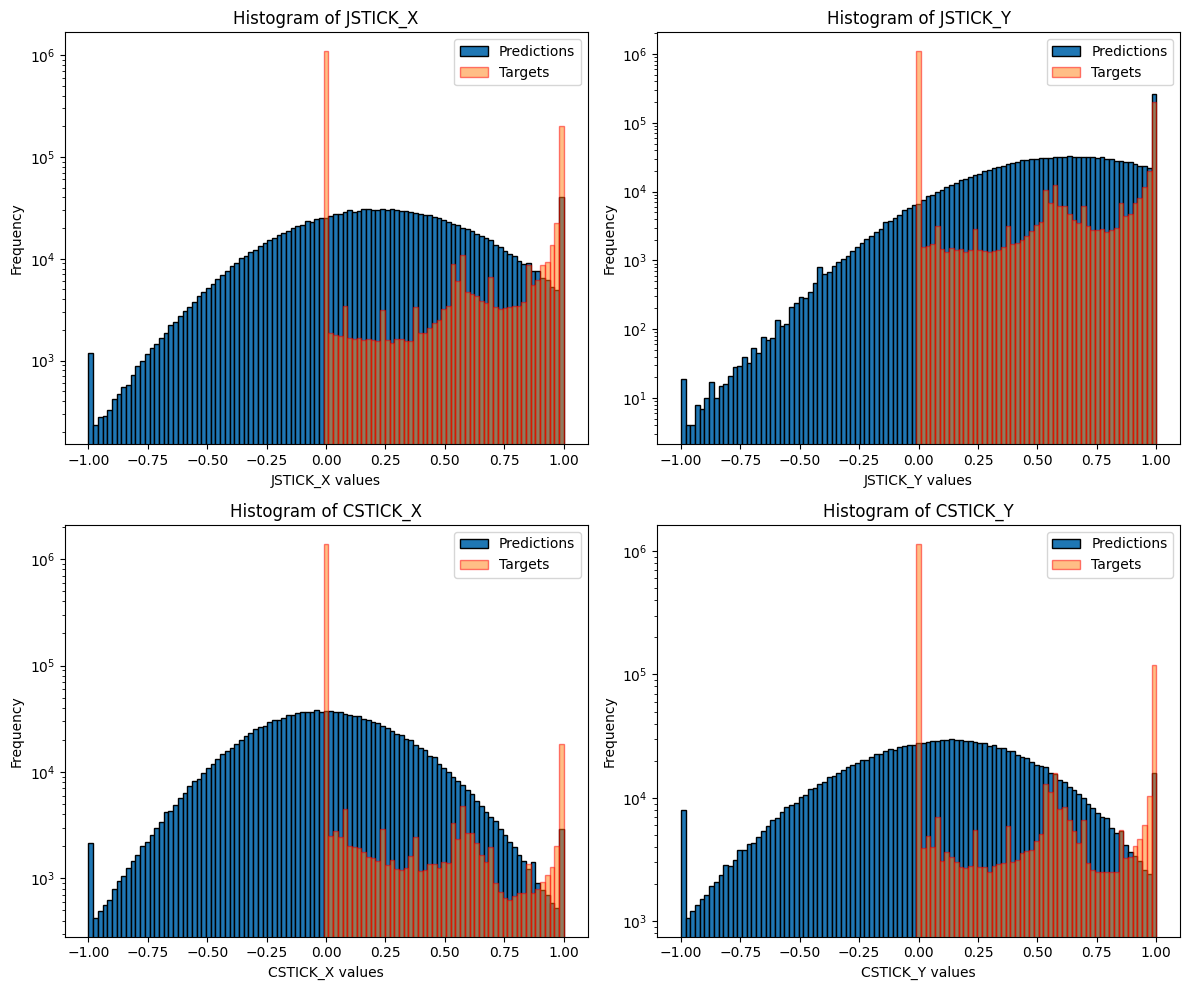

In [ ]:
def stick_histograms(predictions, targets, jstick_n_bins, c_stick_n_bins):
    
    
    # # get the max and min of JSTICK_X, JSTICK_Y, CSTICK_X, and CSTICK_Y
    jstick_x_max, jstick_x_min = np.max(predictions[:, 0, :]), np.min(predictions[:, 0, :])
    jstick_y_max, jstick_y_min = np.max(predictions[:, 1, :]), np.min(predictions[:, 1, :])
    cstick_x_max, cstick_x_min = np.max(predictions[:, 2, :]), np.min(predictions[:, 2, :])
    cstick_y_max, cstick_y_min = np.max(predictions[:, 3, :]), np.min(predictions[:, 3, :])
    
    print(f'Predictions JSTICK_X max: {jstick_x_max}, min: {jstick_x_min}')
    print(f'Predictions JSTICK_Y max: {jstick_y_max}, min: {jstick_y_min}')
    print(f'Predictions CSTICK_X max: {cstick_x_max}, min: {cstick_x_min}')
    print(f'Predictions CSTICK_Y max: {cstick_y_max}, min: {cstick_y_min}')
    
    predictions = np.clip(predictions,-1,1)
    # Histograms
    pred_hist_jstick_x, edges_jstick_x = np.histogram(predictions[:, 0, :], bins=jstick_n_bins, range=(-1, 1))
    target_hist_jstick_x, _ = np.histogram(targets[:, 0, :], bins=jstick_n_bins, range=(-1, 1))
    
    pred_hist_jstick_y, edges_jstick_y = np.histogram(predictions[:, 1, :], bins=jstick_n_bins, range=(-1, 1))
    target_hist_jstick_y, _ = np.histogram(targets[:, 1, :], bins=jstick_n_bins, range=(-1, 1))
    
    pred_hist_cstick_x, edges_cstick_x = np.histogram(predictions[:, 2, :], bins=c_stick_n_bins, range=(-1, 1))
    target_hist_cstick_x, _ = np.histogram(targets[:, 2, :], bins=c_stick_n_bins, range=(-1, 1))
    
    pred_hist_cstick_y, edges_cstick_y = np.histogram(predictions[:, 3, :], bins=c_stick_n_bins, range=(-1, 1))
    target_hist_cstick_y, _ = np.histogram(targets[:, 3, :], bins=c_stick_n_bins, range=(-1, 1))
    
    # Plotting histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # JSTICK_X histogram
    axs[0, 0].bar(edges_jstick_x[:-1], pred_hist_jstick_x, width=np.diff(edges_jstick_x), edgecolor="black", align="edge", label='Predictions')
    axs[0, 0].bar(edges_jstick_x[:-1], target_hist_jstick_x, width=np.diff(edges_jstick_x), edgecolor="red", align="edge", label='Targets', alpha=0.5)
    axs[0, 0].legend()
    axs[0, 0].set_title('Histogram of JSTICK_X')
    axs[0, 0].set_xlabel('JSTICK_X values')
    axs[0, 0].set_ylabel('Frequency')
    axs[0, 0].set_yscale('log')
    
    # JSTICK_Y histogram
    axs[0, 1].bar(edges_jstick_y[:-1], pred_hist_jstick_y, width=np.diff(edges_jstick_y), edgecolor="black", align="edge", label='Predictions')
    axs[0, 1].bar(edges_jstick_y[:-1], target_hist_jstick_y, width=np.diff(edges_jstick_y), edgecolor="red", align="edge", label='Targets', alpha=0.5)
    axs[0, 1].legend()
    axs[0, 1].set_title('Histogram of JSTICK_Y')
    axs[0, 1].set_xlabel('JSTICK_Y values')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].set_yscale('log')
    
    # CSTICK_X histogram
    axs[1, 0].bar(edges_cstick_x[:-1], pred_hist_cstick_x, width=np.diff(edges_cstick_x), edgecolor="black", align="edge", label='Predictions')
    axs[1, 0].bar(edges_cstick_x[:-1], target_hist_cstick_x, width=np.diff(edges_cstick_x), edgecolor="red", align="edge", label='Targets', alpha=0.5)
    axs[1, 0].legend()
    axs[1, 0].set_title('Histogram of CSTICK_X')
    axs[1, 0].set_xlabel('CSTICK_X values')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].set_yscale('log')
    
    # CSTICK_Y histogram
    axs[1, 1].bar(edges_cstick_y[:-1], pred_hist_cstick_y, width=np.diff(edges_cstick_y), edgecolor="black", align="edge", label='Predictions')
    axs[1, 1].bar(edges_cstick_y[:-1], target_hist_cstick_y, width=np.diff(edges_cstick_y), edgecolor="red", align="edge", label='Targets', alpha=0.5)
    axs[1, 1].legend()
    axs[1, 1].set_title('Histogram of CSTICK_Y')
    axs[1, 1].set_xlabel('CSTICK_Y values')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Example usage
# pred: predictions numpy array of shape (batch_size, 9, 60)
# target: targets numpy array of shape (batch_size, 9, 60)
# Adjust bins as needed
stick_histograms(pred, target, 101, 101)


In [ ]:
def confusion_heatmap_none(predictions, targets, bins, label):
    # Clip and flatten the predictions and targets
    predictions = np.clip(predictions, -1, 1).flatten()
    targets = np.clip(targets, -1, 1).flatten()

    # Create a 2D histogram of the data
    heatmap, xedges, yedges = np.histogram2d(predictions, targets, bins=bins, range=[[-1, 1], [-1, 1]])
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))  # Increase figure size
    plt.imshow(heatmap, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    
    # Adding color bar to understand the scale of counts
    plt.colorbar(label='Count')
    
    # Labels for axes
    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    
    # Set x and y ticks to represent the edges of bins
    # plt.xticks((xedges[:-1] + xedges[1:])/2, labels=[f"{edge:.2f}" for edge in xedges[:-1]])
    # plt.yticks((yedges[:-1] + yedges[1:])/2, labels=[f"{edge:.2f}" for edge in yedges[:-1]])
    
    plt.title(f'Heatmap of {label} Predictions vs Targets')
    plt.show()

def confusion_heatmap_normalize_pred(predictions, targets, bins, label):
    predictions = np.clip(predictions   , -1, 1).flatten()
    targets = np.clip(targets   , -1, 1).flatten()

    # Calculate weights for normalization by predicted values
    # Count the occurrences of each predicted bin
    predicted_bins = np.digitize(predictions, bins=np.linspace(-1, 1, bins+1)) - 1
    predicted_bin_counts = np.bincount(predicted_bins, minlength=bins)
    weights_pred = 1 / predicted_bin_counts[predicted_bins]  # Weights are reciprocal of the counts

    # Create a 2D histogram of the data with weights
    heatmap, xedges, yedges = np.histogram2d(predictions, targets, bins=bins, range=[[-1, 1], [-1, 1]], weights=weights_pred)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    plt.colorbar(label='Proportion')
    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title(f'Heatmap {label} Normalized by Predicted')
    plt.show()

def confusion_heatmap_normalize_true(predictions, targets, bins, label):
    predictions = np.clip(predictions, -1, 1).flatten()
    targets = np.clip(targets, -1, 1).flatten()

    # Calculate weights for normalization by true values
    # Count the occurrences of each true bin
    true_bins = np.digitize(targets, bins=np.linspace(-1, 1, bins+1)) - 1
    true_bin_counts = np.bincount(true_bins, minlength=bins)
    weights_true = 1 / true_bin_counts[true_bins]  # Weights are reciprocal of the counts

    # Create a 2D histogram of the data with weights
    heatmap, xedges, yedges = np.histogram2d(predictions, targets, bins=bins, range=[[-1, 1], [-1, 1]], weights=weights_true)

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    plt.colorbar(label='Proportion')
    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title(f'Heatmap {label} Normalized by True')
    plt.show()

def confusion_heatmaps(predictions, targets, bins, label):
    confusion_heatmap_none(pred[:, 0, :], target[:, 0, :], bins, label)
    confusion_heatmap_normalize_pred(pred[:, 0, :], target[:, 0, :],  bins, label)
    confusion_heatmap_normalize_true(pred[:, 0, :], target[:, 0, :],  bins, label)

bins = 30
# confusion_heatmaps(pred[:, 0, :], target[:, 0, :],  bins, 'JSTICK_X')
# confusion_heatmaps(pred[:, 1, :], target[:, 1, :],  bins, 'JSTICK_Y')

# confusion_heatmaps(np.arctan2(pred[:, 1, :], pred[:, 0, :]), np.arctan2(target[:, 1, :], target[:, 0, :]),  bins, 'J-Stick Angle')
# confusion_heatmaps(pred[:, 1, :]**2 + pred[:, 0, :]**2, target[:, 1, :]**2 + target[:, 0, :]**2,  bins, 'J-Stick Radius')

# confusion_heatmaps(pred[:, 2, :], target[:, 2, :],  bins, 'CSTICK_X')
# confusion_heatmaps(pred[:, 3, :], target[:, 3, :],  bins, 'CSTICK_Y')

# confusion_heatmaps(np.arctan2(pred[:, 3, :],  pred[:, 2, :]), np.arctan2(target[:, 3, :] , target[:, 2, :]),  bins, 'J-Stick Angle')
# confusion_heatmaps(pred[:, 2, :]**2 + pred[:, 3, :]**2, target[:, 2, :]**2 + target[:, 3, :]**2,  bins, 'J-Stick Radius')


Get a sense of how often the model predicts zeros. We look at the distribution of the number of frames a button is held over all games for the predictions and the labels.

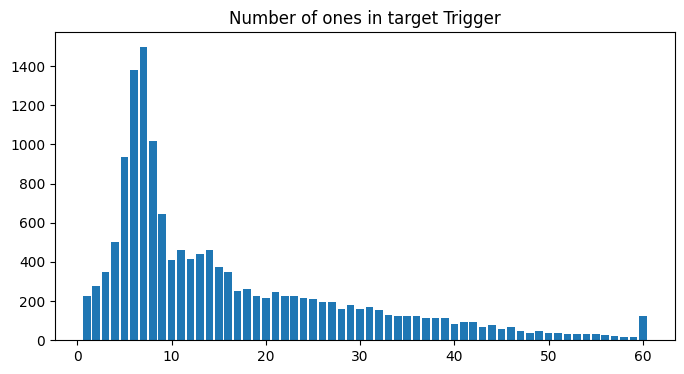

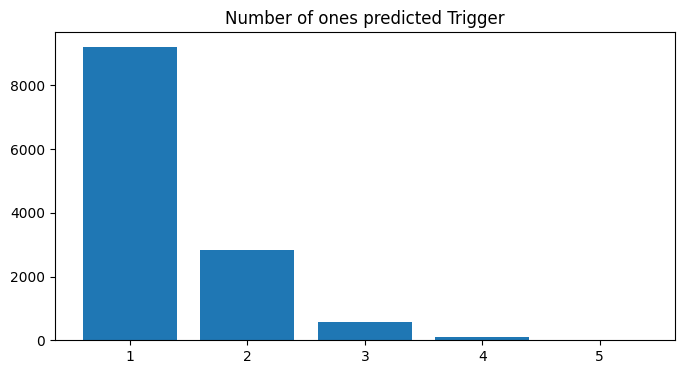

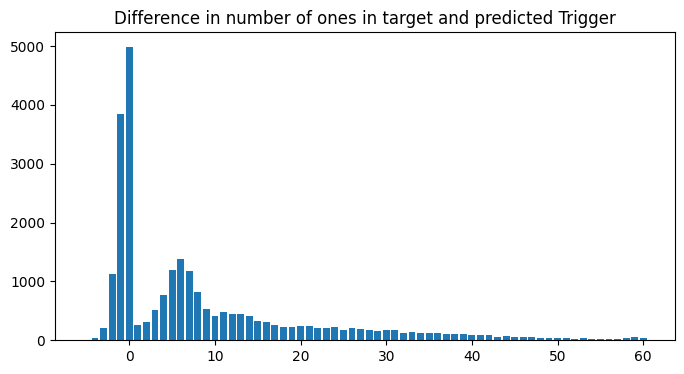

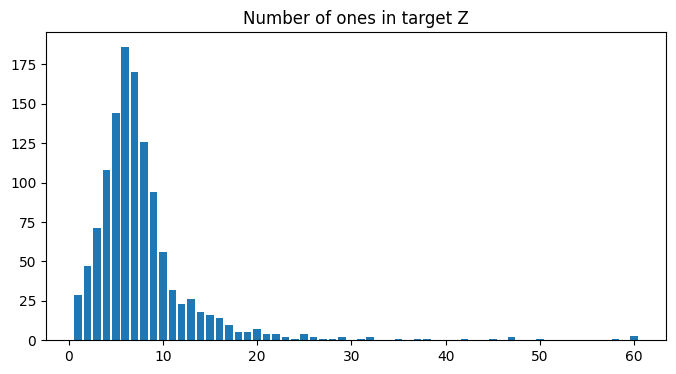

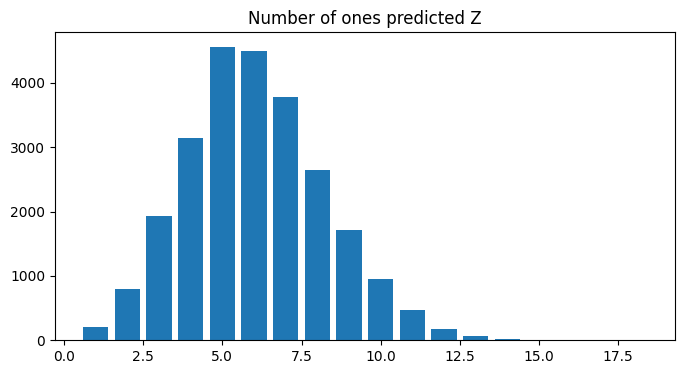

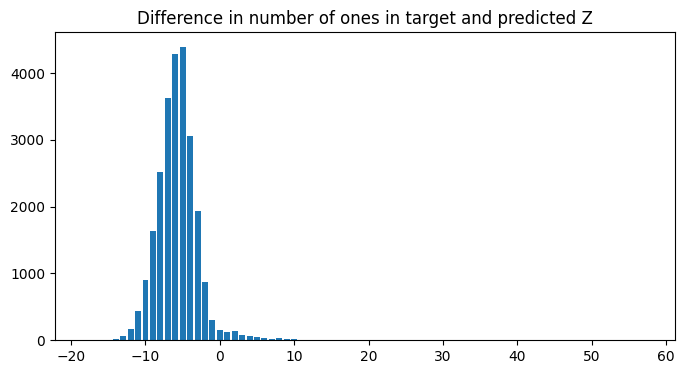

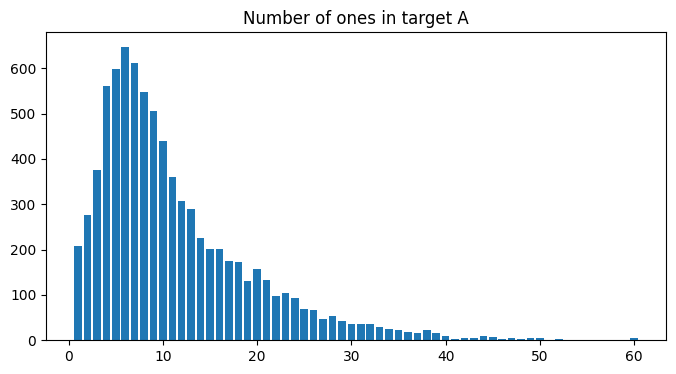

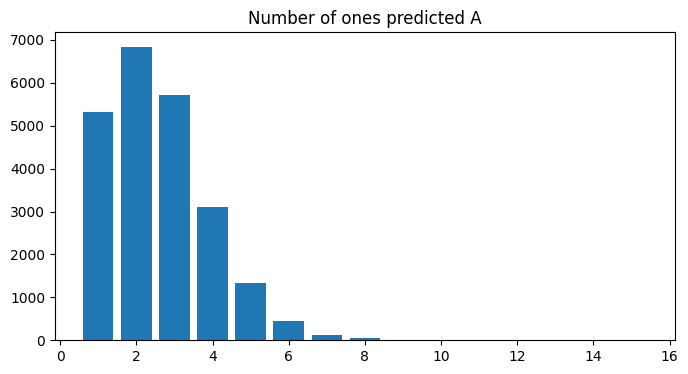

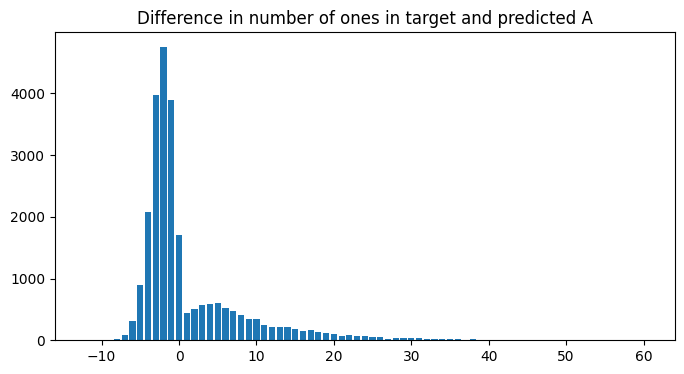

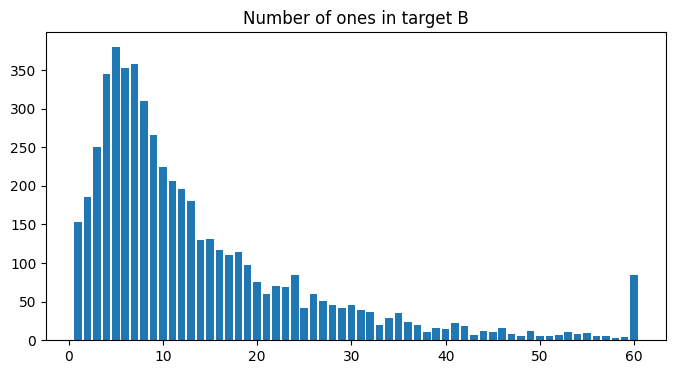

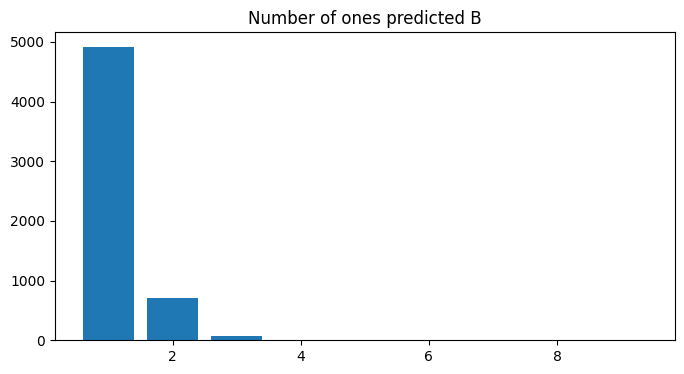

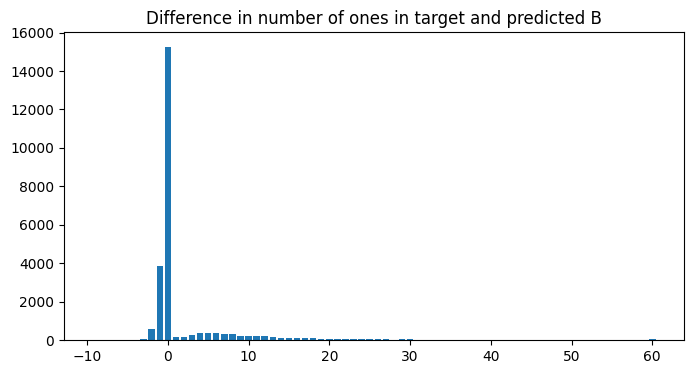

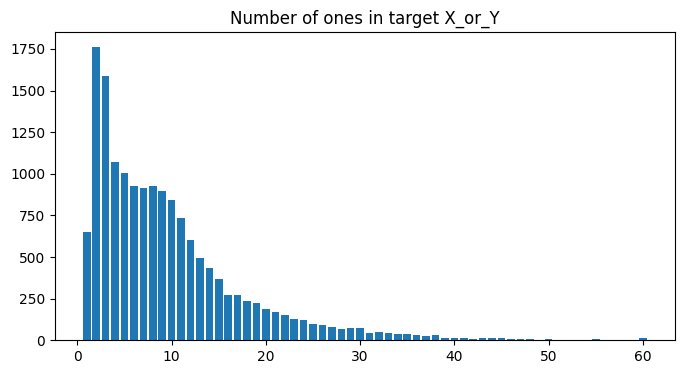

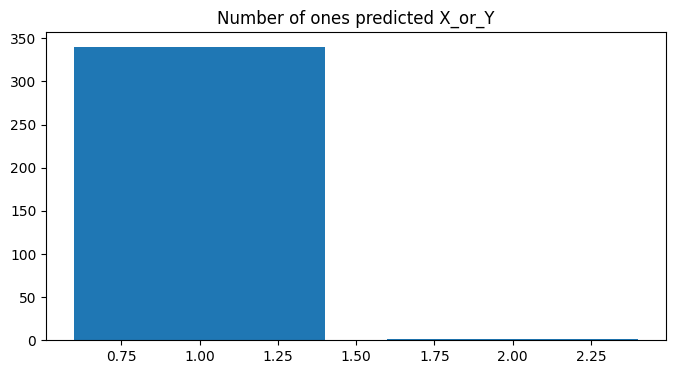

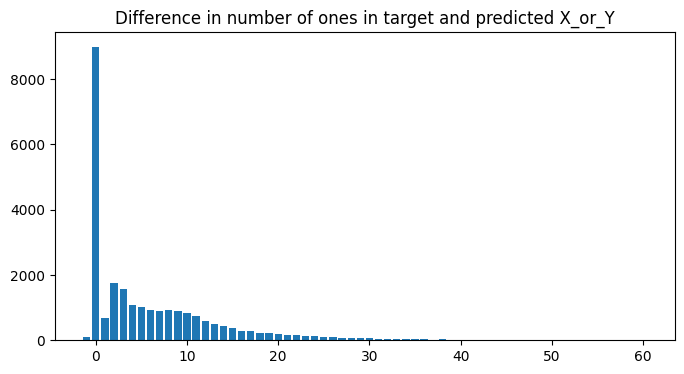

In [ ]:
# convert the target and predicted to binary numpy
predicted_buttons = pred[:,-5:,:] >= .5
target_buttons = target[:,-5:,:] == 1
predicted_and_target_one = np.multiply(predicted_buttons ,target_buttons)

# sum over the buttons to get the number of frames the button is held
target_button_sum = np.sum(target_buttons, axis = 2)
pred_button_sum = np.sum(predicted_buttons, axis = 2)

prediction_and_target_one_sum = np.sum(predicted_and_target_one, axis = 2)
# take the difference between the number of frames the button is held in the prediction and the target
difference = target_button_sum - pred_button_sum

order = ['Trigger', 'Z', 'A', 'B', 'X_or_Y']
for i, label in enumerate(order):
    pred_unique, pred_counts = np.unique(pred_button_sum[:,i], return_counts=True)
    target_unique, target_counts = np.unique(target_button_sum[:,i], return_counts=True)
    diff_unique, diff_counts = np.unique(difference[:,i], return_counts=True)
    both_one_unique, both_one_counts = np.unique(prediction_and_target_one_sum[:,i], return_counts=True)

    plt.figure(figsize=(8, 4))
    plt.title(f'Number of ones in target {label}')
    plt.bar(target_unique[1:],target_counts[1:])
    # plt.bar(target_unique,target_counts)
    plt.show()
    
    plt.figure(figsize=(8, 4))
    plt.title(f'Number of ones predicted {label}')
    plt.bar(pred_unique[1:],pred_counts[1:])
    # plt.bar(pred_unique,pred_counts)
    plt.show()
    
    plt.figure(figsize=(8, 4))
    plt.title(f'Difference in number of ones in target and predicted {label}')
    plt.bar(diff_unique,diff_counts)
    plt.show()
    
    




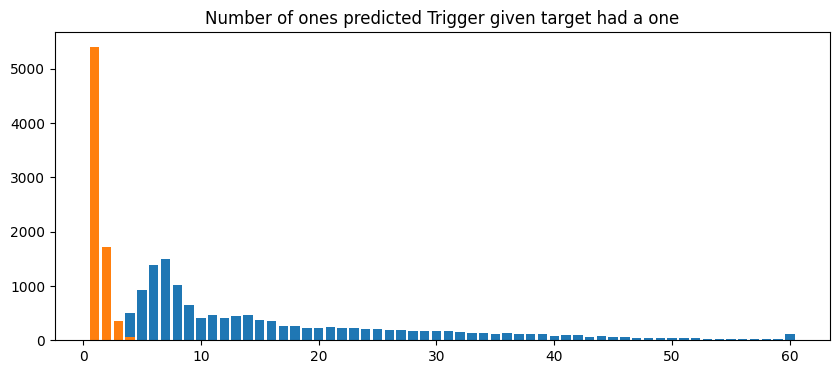

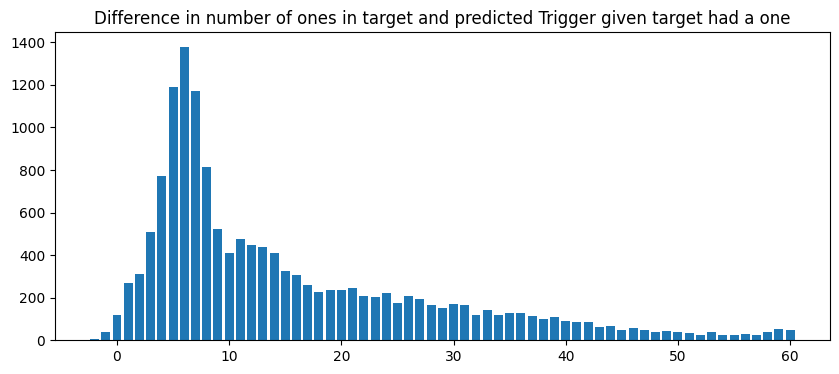

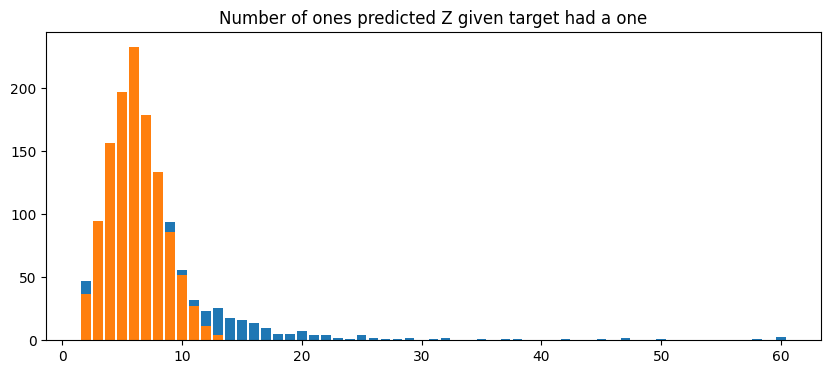

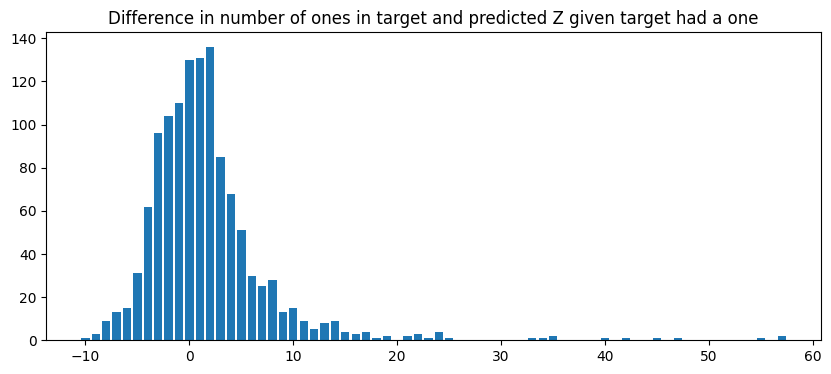

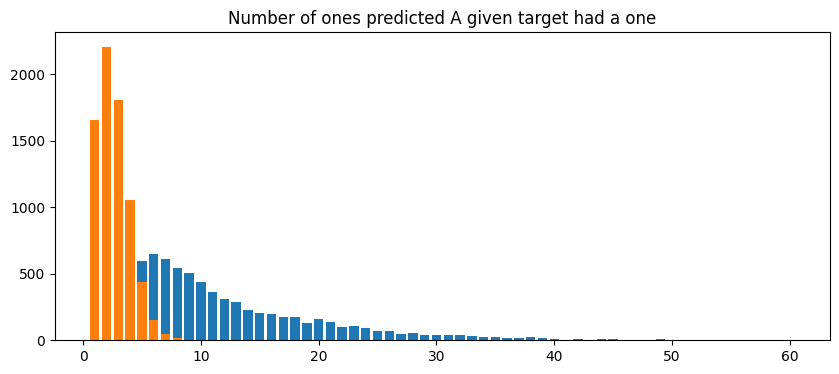

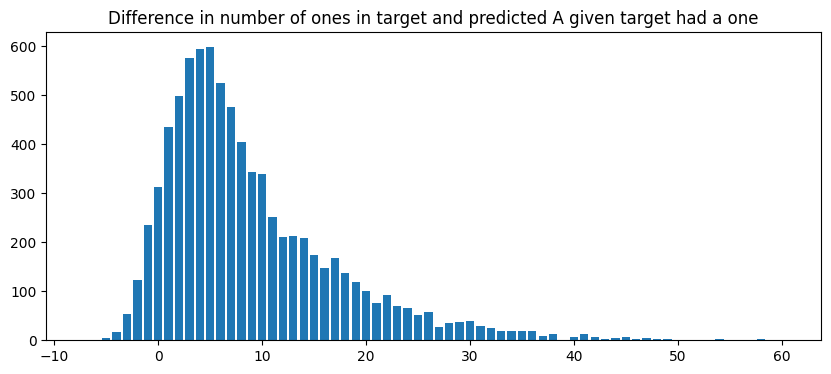

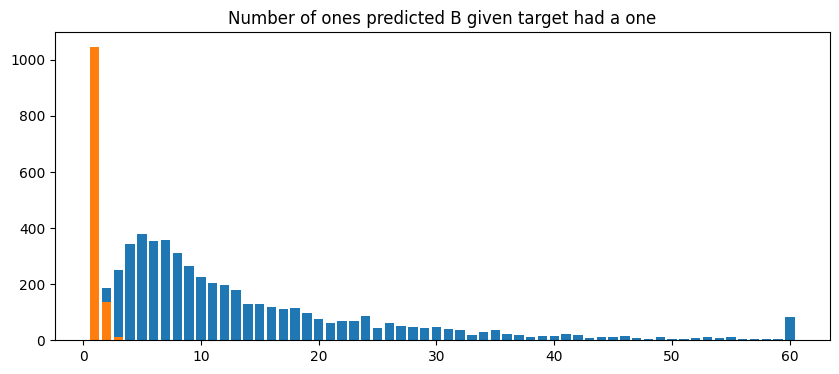

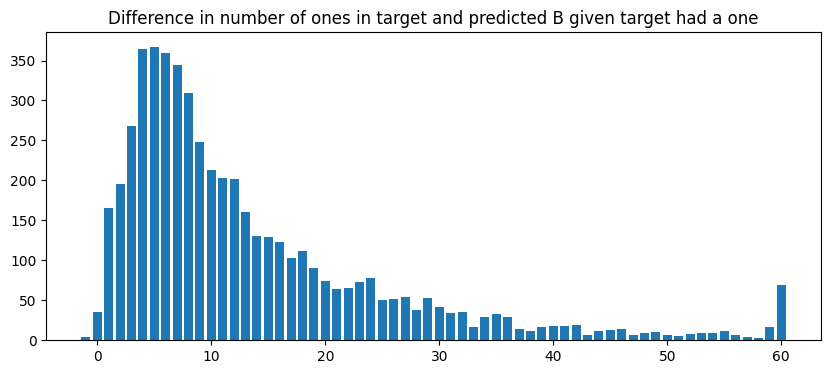

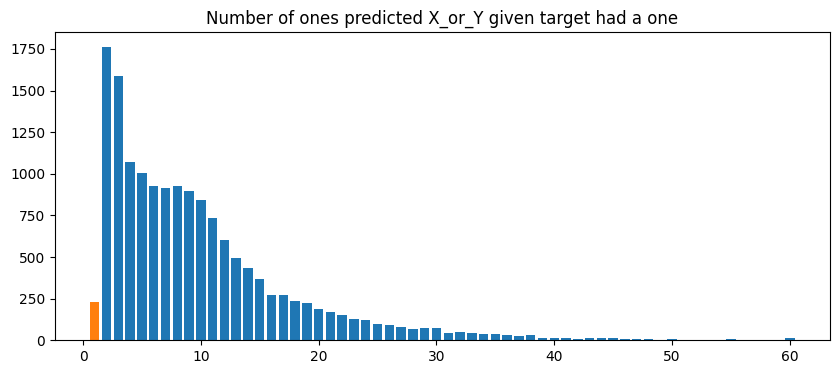

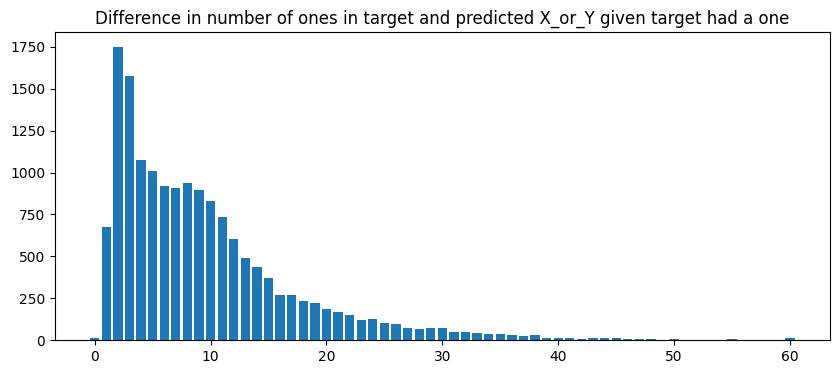

In [ ]:
# convert the target and predicted to binary numpy
predicted_buttons = pred[:,-5:,:] >= .5
target_buttons = target[:,-5:,:] == 1
predicted_and_target_one = np.multiply(predicted_buttons ,target_buttons)

# sum over the buttons to get the number of frames the button is held
target_button_sum = np.sum(target_buttons, axis = 2)
pred_button_sum = np.sum(predicted_buttons, axis = 2)

prediction_and_target_one_sum = np.sum(predicted_and_target_one, axis = 2)
# take the difference between the number of frames the button is held in the prediction and the target
difference = target_button_sum - pred_button_sum

order = ['Trigger', 'Z', 'A', 'B', 'X_or_Y']
for i, label in enumerate(order):
    target_non_zero = target_button_sum[:,i] > 0
    # print(target_non_zero.shape)
    pred_unique, pred_counts = np.unique(pred_button_sum[target_non_zero,i], return_counts=True)
    target_unique, target_counts = np.unique(target_button_sum[target_non_zero,i], return_counts=True)
    diff_unique, diff_counts = np.unique(difference[target_non_zero,i], return_counts=True)
    both_one_unique, both_one_counts = np.unique(prediction_and_target_one_sum[target_non_zero,i], return_counts=True)

    plt.figure(figsize=(10, 4))
    plt.title(f'Number of ones in target {label} given target had a one')
    plt.bar(target_unique[1:],target_counts[1:])
    # plt.bar(target_unique,target_counts)
    # plt.show()
    
    # plt.figure(figsize=(10, 4))
    plt.title(f'Number of ones predicted {label} given target had a one')
    plt.bar(pred_unique[1:],pred_counts[1:])
    # plt.bar(pred_unique,pred_counts)
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.title(f'Difference in number of ones in target and predicted {label} given target had a one')
    plt.bar(diff_unique,diff_counts)
    plt.show()
    


Once we get the distributions of the ones better (using a better loss function) and deal with the gradient problem we can focus in on the details of button presses. A confusion matrix where we look at the number of distinct times the button is pressed during a segment (it is pressed once but the prediction is two distinct presses). Given a button is pressed once and the prediction is that the button was pressed once, does the autoencoder predict the button was pressed at the same time? How many frames before the actual button was press does the autoencoder predict it was first pressed. How many frames is the end of the predicted button press off from the actual end of the button press.

Given any button was pressed, what is the probability that it predicted a button was pressed (not necessarily the one that was actually pressed). 
